<a href="https://colab.research.google.com/github/ansariwaleed/GNN-implementations/blob/main/Hands_On_Graph_Neural_Networks_Using_Python_ch3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

let's start by importing the neccessary libraries:

In [ ]:
import numpy as np

Then, we need to set the CONTEXT_SIZE variable to 2 and bring in the text we want to analyzwe

In [ ]:
np.random.seed(0)

CONTEXT_SIZE = 2

text = """Lorem ipsum dolor sit amet, consectetur adipiscing elit. Nunc eu sem
scelerisque, dictum eros aliquam, accumsan quam. Pellentesque tempus, lorem ut
semper fermentum, ante turpis accumsan ex, sit amet ultricies tortor erat quis
nulla. Nunc consectetur ligula sit amet purus porttitor, vel tempus tortor
scelerisque. Vestibulum ante ipsum primis in faucibus orci luctus et ultrices
posuere cubilia curae; Quisque suscipit ligula nec faucibus accumsan. Duis
vulputate massa sit amet viverra hendrerit. Integer maximus quis sapien id
convallis. Donec elementum placerat ex laoreet gravida. Praesent quis enim
facilisis, bibendum est nec, pharetra ex. Etiam pharetra congue justo, eget
imperdiet diam varius non. Mauris dolor lectus, interdum in laoreet quis,
faucibus vitae velit. Donec lacinia dui eget maximus cursus. Class aptent taciti
sociosqu ad litora torquent per conubia nostra, per inceptos himenaeos. Vivamus
tincidunt velit eget nisi ornare convallis. Pellentesque habitant morbi
tristique senectus et netus et malesuada fames ac turpis egestas. Donec
tristique ultrices tortor at accumsan.
""".split()

# Create skipgrams
skipgrams = []
for i in range(CONTEXT_SIZE, len(text) - CONTEXT_SIZE):
    array = [text[j] for j in np.arange(i - CONTEXT_SIZE, i + CONTEXT_SIZE + 1) if j != i]
    skipgrams.append((text[i], array))

print(skipgrams[0:2])


[('dolor', ['Lorem', 'ipsum', 'sit', 'amet,']), ('sit', ['ipsum', 'dolor', 'amet,', 'consectetur'])]


In [ ]:
vocab = set(text)
VOCAB_SIZE = len(vocab)
print(f"Length of vocabulary = {VOCAB_SIZE}")

Length of vocabulary = 121


We can implement this model using the gensim library, which is also used in the official implementation
of DeepWalk. We can then build the vocabulary and train our model based on the previous text:

In [ ]:
!pip install -qU gensim

We initialize a skip-gram model with a Word2vec object and sg = 1 parameter (skip-gram = 1)

In [ ]:
from gensim.models.word2vec import Word2Vec

# Create Word2Vec
model = Word2Vec([text],
                 sg=1,   # Skip-gram
                 vector_size=10,
                 min_count=0,
                 window=2,
                 workers=1,
                 seed=0)

it's a good idea to check the shape of our first weight matrix, It should correspond to the vocabulary size and the word embedding's dimensionallity:

In [ ]:
print(f'Shape of W_embed: {model.wv.vectors.shape}')

Shape of W_embed: (121, 10)


Next we train the model for 10 epochs

In [ ]:
model.train([text], total_examples=model.corpus_count, epochs = 10)

(723, 1560)

Finally, we can print a word embedding to see what the result of this training looks lik:

In [ ]:
print("Word embeddings :")
word = model.wv.index_to_key[0]
print(f"Word: {word}")
print(model.wv[0])

Word embeddings :
Word: sit
[ 0.07254551  0.03830492  0.00243661 -0.04084453 -0.03039765 -0.08056319
 -0.09818466 -0.09601782 -0.06550466  0.0710962 ]


In [ ]:
print(model.wv.most_similar(model.wv.index_to_key[0]))


[('elit.', 0.9055760502815247), ('senectus', 0.7631184458732605), ('nec,', 0.626630425453186), ('lacinia', 0.6251636743545532), ('Etiam', 0.619288444519043), ('nec', 0.605995774269104), ('enim', 0.5770799517631531), ('egestas.', 0.5580589771270752), ('ante', 0.5522923469543457), ('Quisque', 0.5491312742233276)]


In [ ]:
print(model.vector_size)


10


Let's implement a randomwalk fucntion using networkx graphg:

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random
random.seed(0)

We generate a random graph thanks to the erdos_renyi_graph function with a fixed
number of nodes (10) and a predefined probability of creating an edge between two nodes (0.3):

In [ ]:
G = nx.erdos_renyi_graph(10, 0.3, seed=1, directed=False)

we plot this random graph to see what it looks like:

/usr/local/lib/python3.11/dist-packages/networkx/drawing/nx_pylab.py:457: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


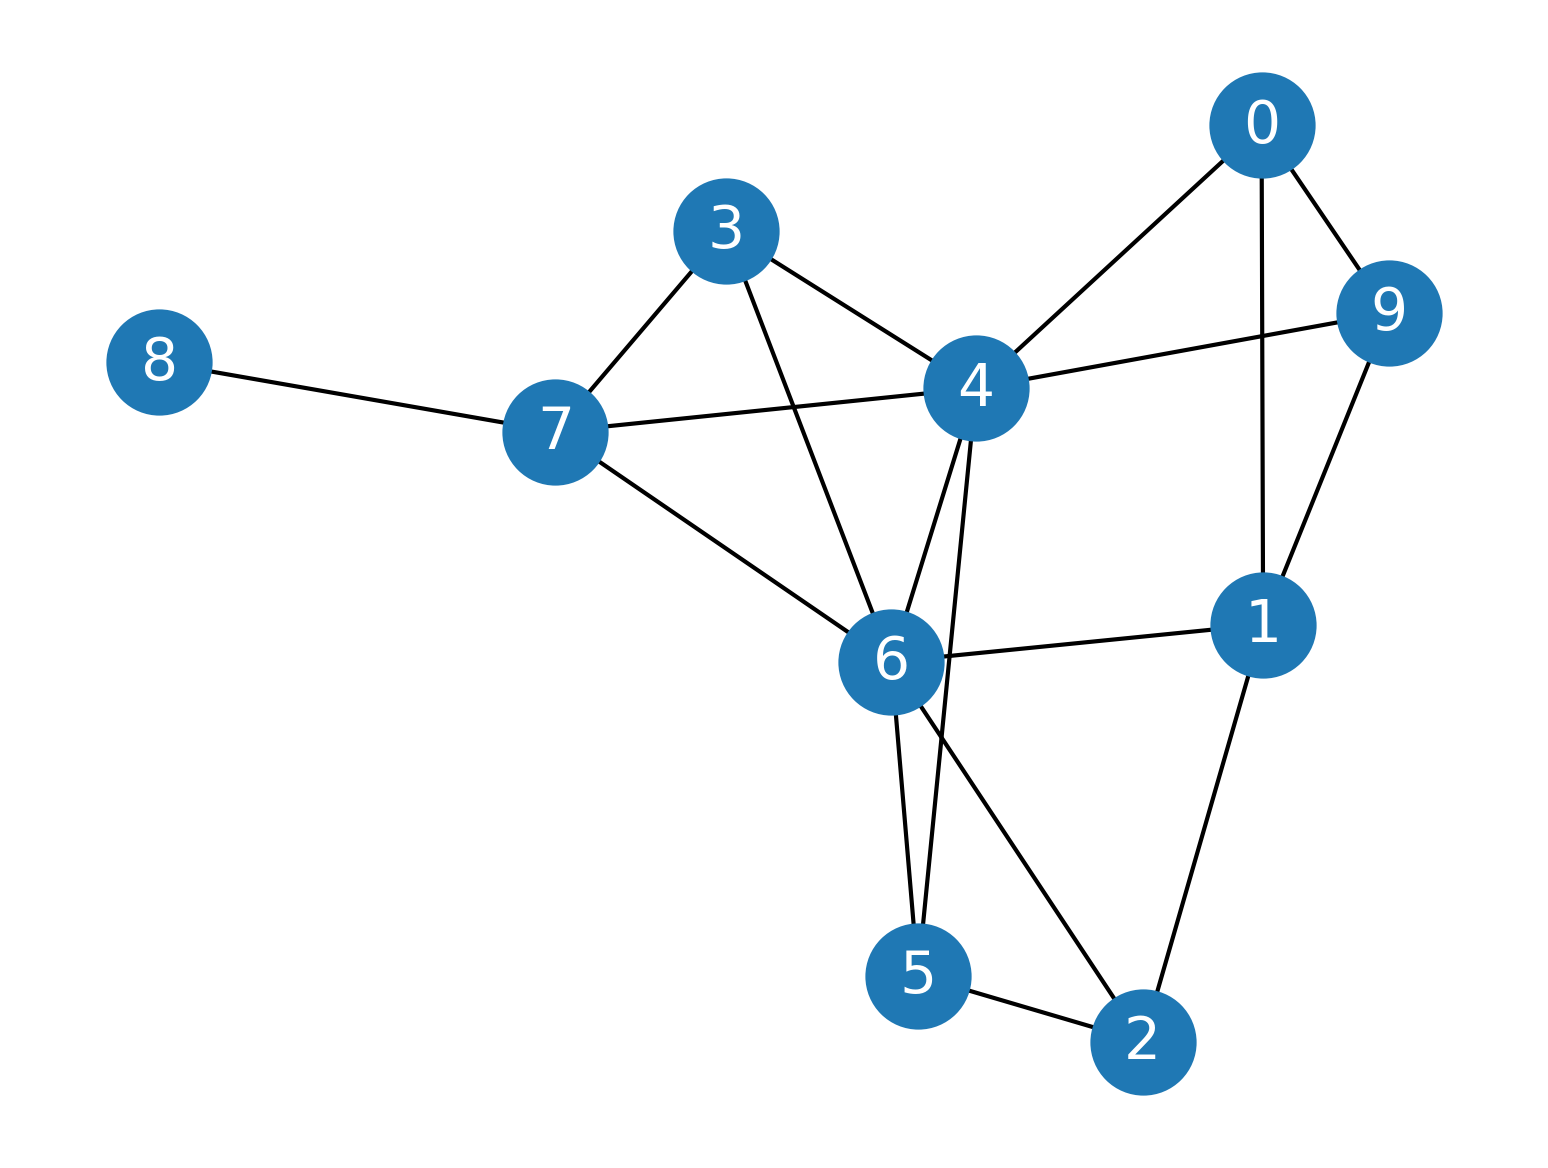

In [ ]:
plt.figure(dpi=300)
plt.axis('off')
nx.draw_networkx(G,
                 pos = nx.spring_layout(G, seed=0),
                 node_size =600,
                 cmap="coolwam",
                 font_size=14,
                 font_color='white'
)

Let’s implement random walks with a simple function. This function takes two parameters:
the starting node (start) and the length of the walk (length). At every step, we randomly
select a neighboring node (using np.random.choice) until the walk is complete:

In [ ]:
def random_walk(start, length):
  walk = [str(start)] #starting node

  for i in range(length):
    neighbour = [node for node in G.neighbors(start)]
    next_node = np.random.choice(neighbour, 1)[0]
    walk.append(str(next_node))
    start = next_node

  return walk

Next we print the result of this functions with the starring node as 0 and a lenght of 10:

In [ ]:
print(random_walk(0, 10))

['0', '1', '9', '1', '0', '4', '6', '7', '6', '5', '6']


##Implementing DeepWalk

Let's import the dataset using nx.karate_club_graph():

In [ ]:
G = nx.karate_club_graph()

Next we need to covert string class label into a numerical values(Mr. Hi = 0, Officer = 1)

In [ ]:
labels = []
for node in G.nodes:
  label = G.nodes[node]['club']
  labels.append(1 if label == 'Officer' else 0)

Let's plot this graph using our new labels:

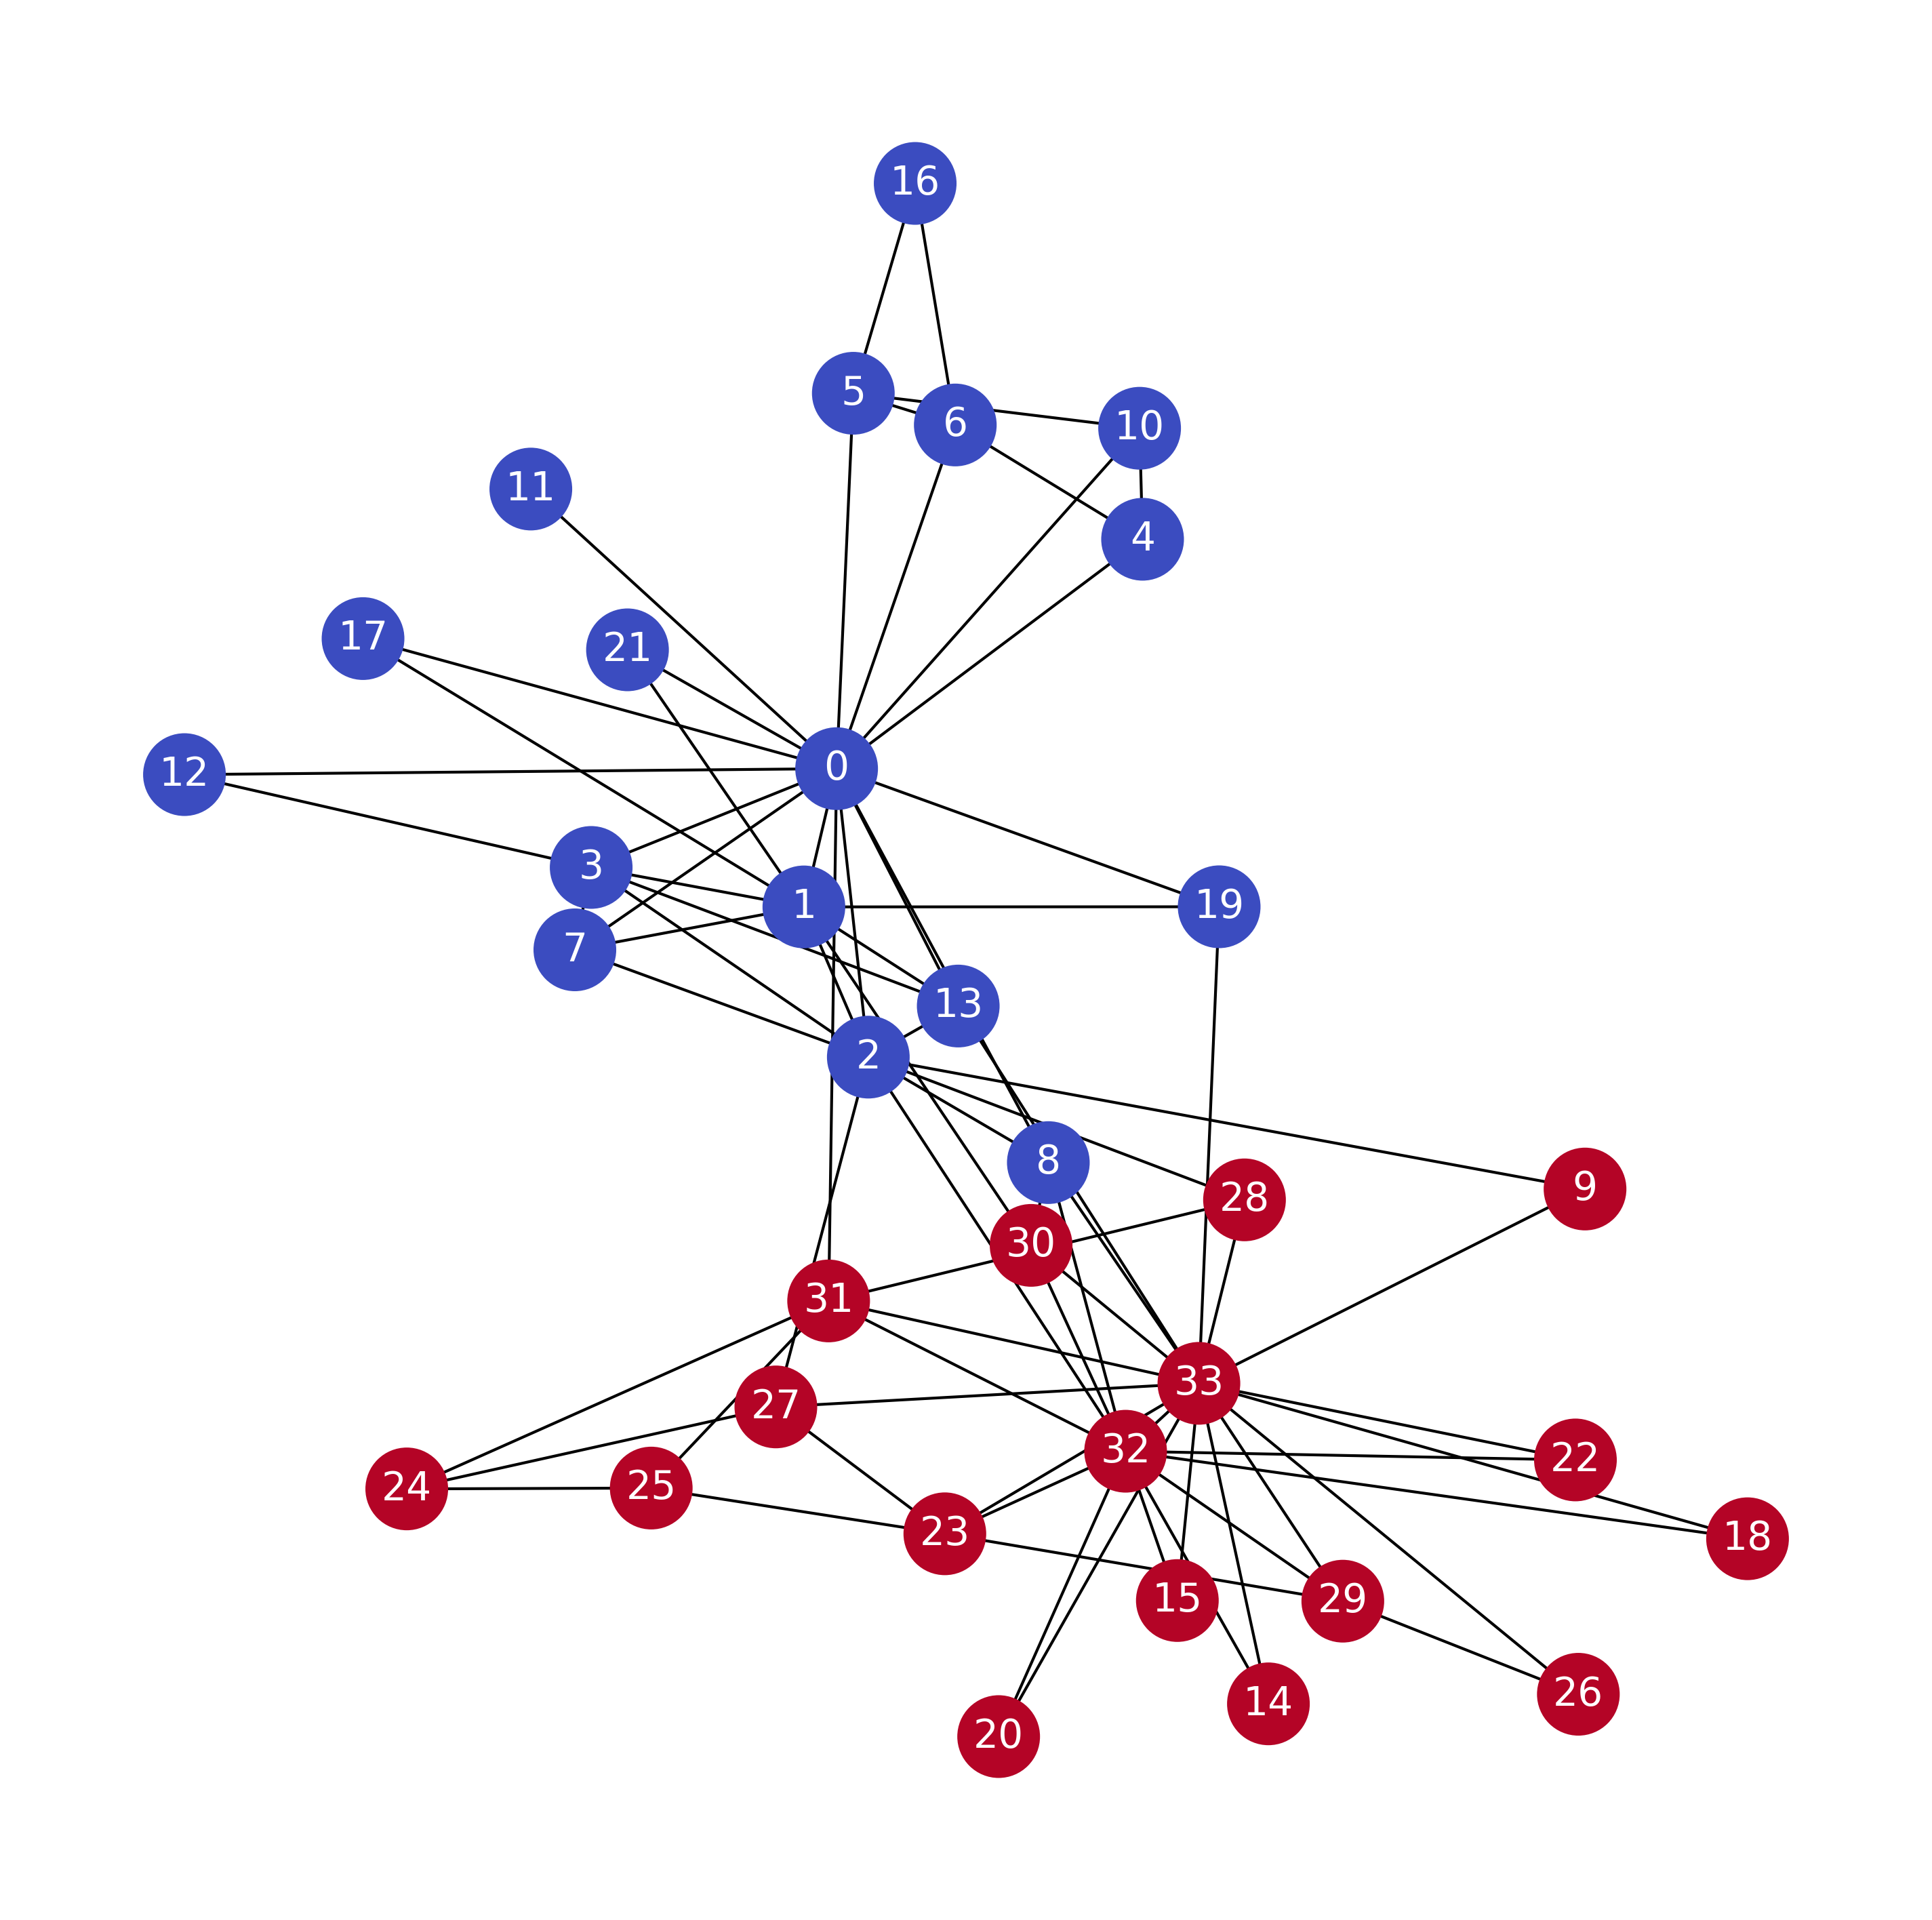

In [ ]:
plt.figure(figsize=(12,12), dpi=300)
plt.axis('off')
nx.draw_networkx(G,
                 pos = nx.spring_layout(G, seed=0),
                 node_color=labels,
                 node_size =800,
                 cmap="coolwarm", # Corrected the typo here from 'coolwam' to 'coolwarm'
                 font_size=14,
                 font_color='white',
)

The next step is to generate our dataset, the random walks. We want to be as exhaustive as possible,
which is why we will create 80 random walks of a length of 10 for every node in the graph:

In [ ]:
walks = []
for node in G.nodes:
  for _ in range (80):
    walks.append(random_walk(node, 10))

let's print a walk to verify that its correct:

In [ ]:
print(walks[0])

['0', '10', '0', '17', '0', '2', '13', '0', '2', '9', '33']


The final step consists of implementing Word2Vec. Here, we use the skip-gram model previously
seen with H-Softmax. You can play with the other parameters to improve the quality of
the embeddings:

In [ ]:
model = Word2Vec(walks,
                 hs =1,
                 sg=1,
                 vector_size = 100,
                 window=10,
                 workers =2,
                 seed = 0)

In [ ]:
model.train(walks, total_examples=model.corpus_count,
epochs=30, report_delay=1)

(187064, 897600)

Now that our model is trained, let’s see its different applications. The first one allows us to find the most similar nodes to a given one (in terms of cosine similarity):

In [ ]:
print('Nodes that are the most similar to node 0:')
for similarity in model.wv.most_similar(positive=['0']):
 print(f' {similarity}')

Nodes that are the most similar to node 0:
 ('4', 0.6678857207298279)
 ('10', 0.5978456139564514)
 ('5', 0.5812379717826843)
 ('7', 0.5780786871910095)
 ('21', 0.5764469504356384)
 ('6', 0.5744643807411194)
 ('17', 0.5662969946861267)
 ('16', 0.5486118197441101)
 ('12', 0.5396786332130432)
 ('11', 0.5337685346603394)


Another important application is calculating the similarity score between two nodes. It can
be performed as follows:

In [ ]:
# Similarity between two nodes
print(f"Similarity between node 0 and 4: {model.wv.similarity('0', '4')}")

Similarity between node 0 and 4: 0.6678857803344727


We can plot the resulting embeddings using t-distributed stochastic neighbor embedding (t-SNE)
to visualize these high-dimensional vectors in 2D:

In [ ]:
from sklearn.manifold import TSNE

We create two arrays: one to store the word embeddings and the other one to store the labels:

In [ ]:
nodes_wv = np.array([model.wv.get_vector(str(i)) for i in range(len(model.wv))])
labels = np.array(labels)

Next, we train the t-SNE model with two dimensions (n_components=2) on the embeddings:

In [ ]:
tsne = TSNE(n_components=2,
            learning_rate='auto',
            init='pca',
            random_state=0).fit_transform(nodes_wv)

Finally, let’s plot the 2D vectors produced by the trained t-SNE model with the corresponding labels:

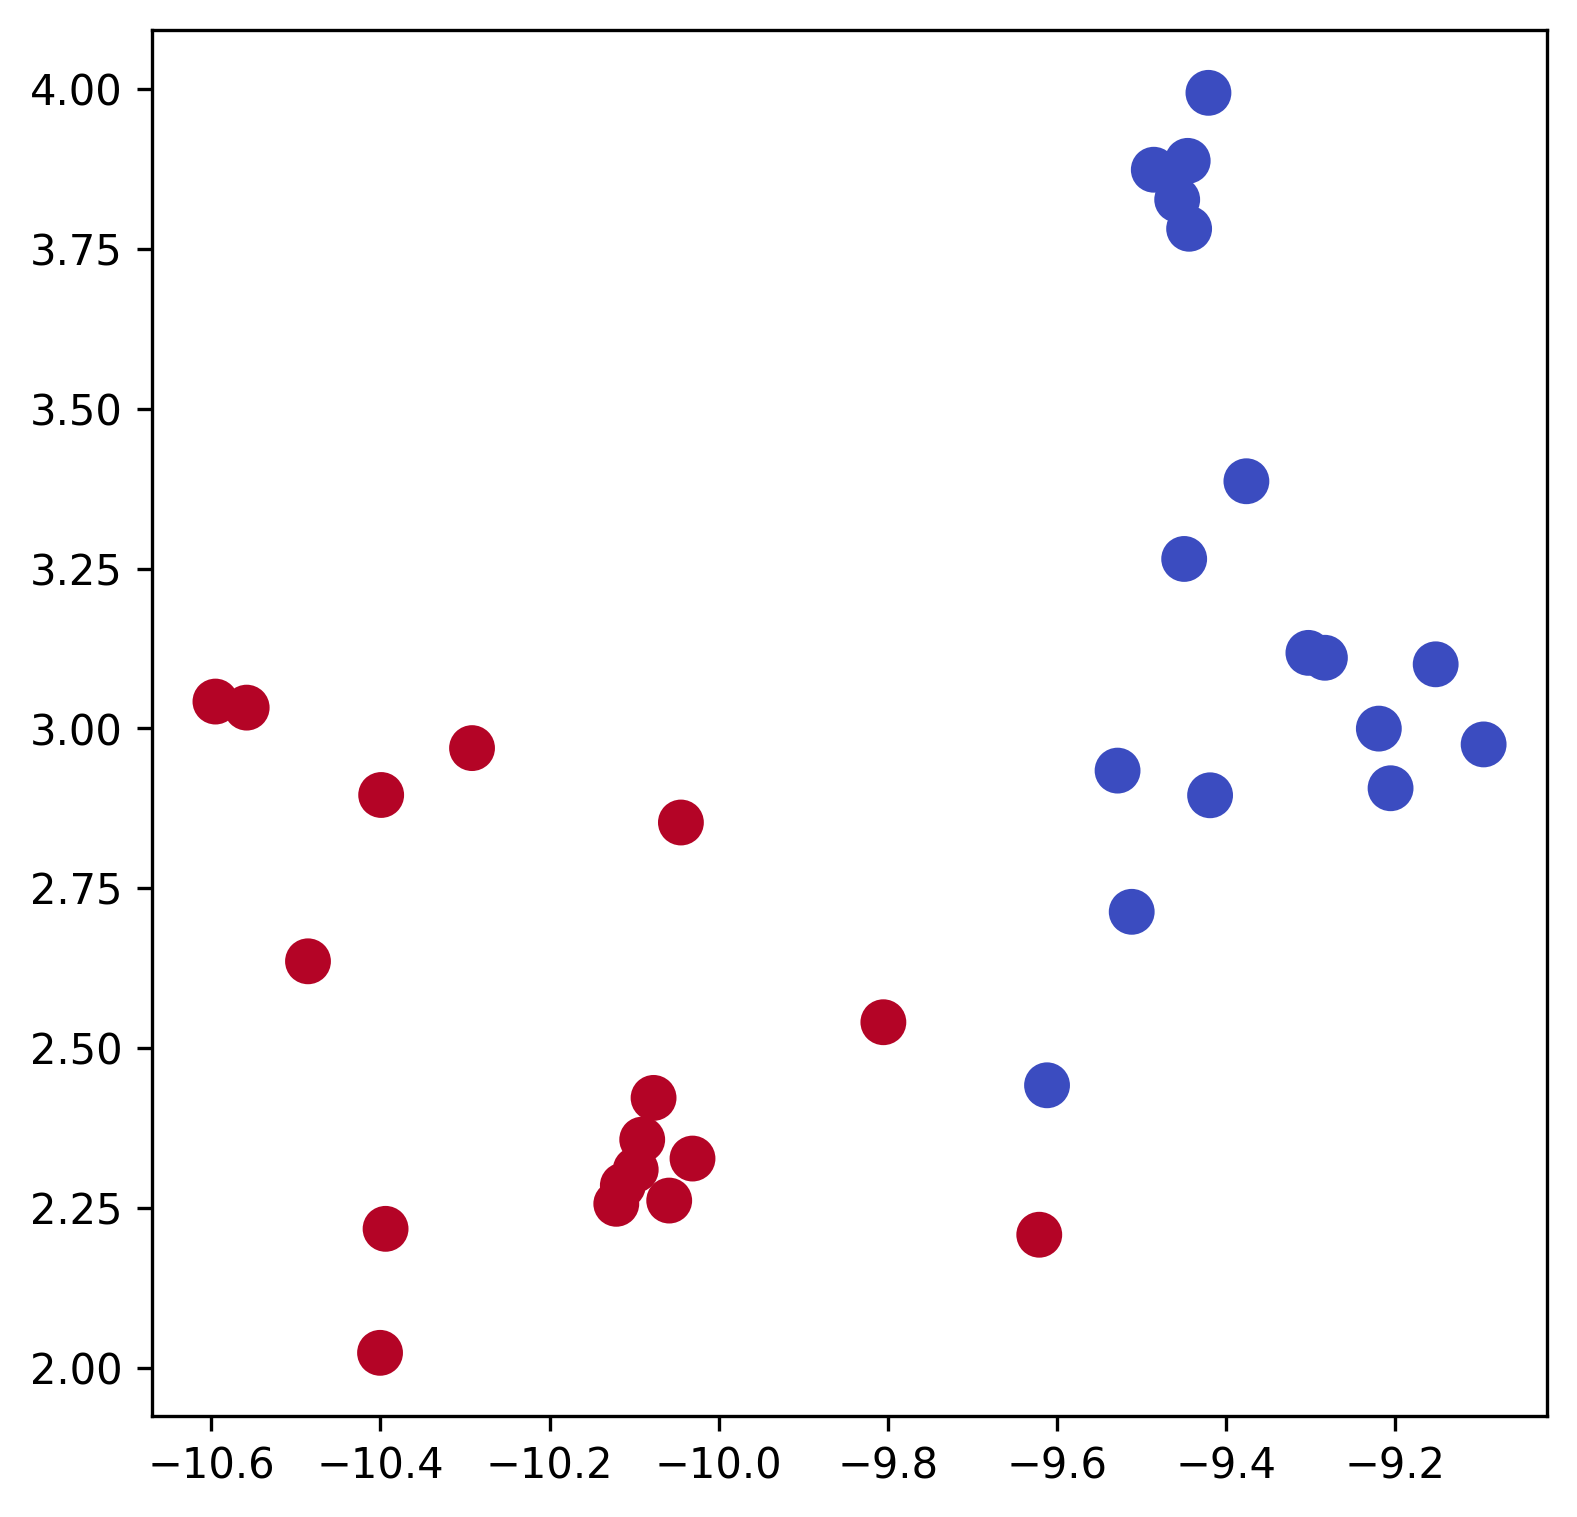

In [ ]:
plt.figure(figsize=(6, 6), dpi=300)
plt.scatter(tsne[:, 0], tsne[:, 1], s=100, c=labels,
cmap="coolwarm")
plt.show()

#Classifing this using random forest

We import a Random Forest model from sklearn, which is a popular choice when it comes
to classification. The accuracy score is the metric we’ll use to evaluate this model:

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

We need to split the embeddings into two groups: training and test data. A simple way of doing
it is to create masks as follows:

In [ ]:
train_mask = [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22,
24, 26, 28]
test_mask = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23,
25, 27, 29, 30, 31, 32, 33]

Next, we train the Random Forest classifier on the training data with the appropriate labels:

In [ ]:
clf = RandomForestClassifier(random_state=0)
clf.fit(nodes_wv[train_mask], labels[train_mask])

RandomForestClassifier(random_state=0)

Finally, we evaluate the trained model on the test data based on its accuracy score:

In [ ]:
y_pred = clf.predict(nodes_wv[test_mask])
accuracy_score(y_pred, labels[test_mask])

0.9473684210526315

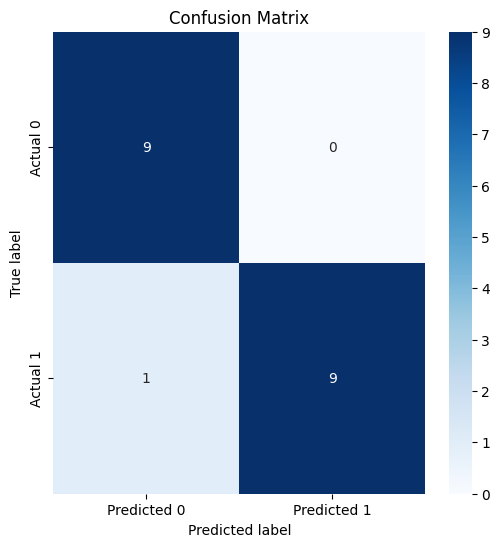

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(labels[test_mask], y_pred)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
sample_node = nodes_wv[5]  # Example node embedding
pred_prob = clf.predict_proba([sample_node])

print(f"Class 0 Probability: {pred_prob[0][0]:.4f}")
print(f"Class 1 Probability: {pred_prob[0][1]:.4f}")


Class 0 Probability: 0.8700
Class 1 Probability: 0.1300


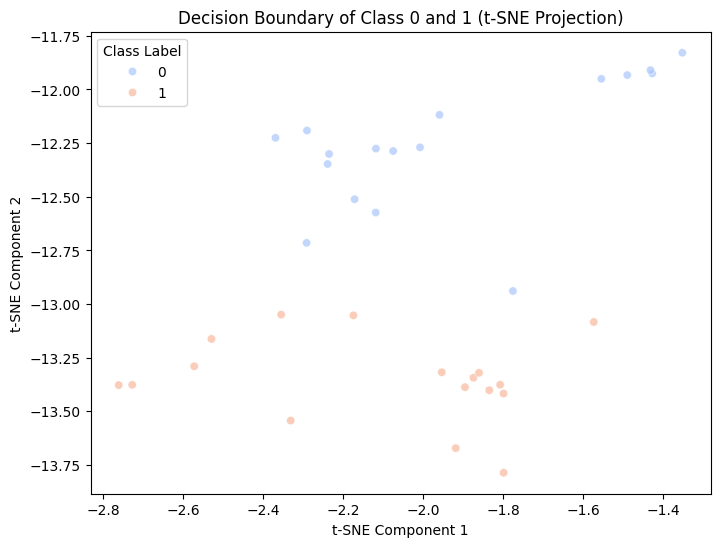

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(nodes_wv)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=embeddings_2d[:, 0], y=embeddings_2d[:, 1], hue=labels, palette="coolwarm", alpha=0.7)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("Decision Boundary of Class 0 and 1 (t-SNE Projection)")
plt.legend(title="Class Label")
plt.show()


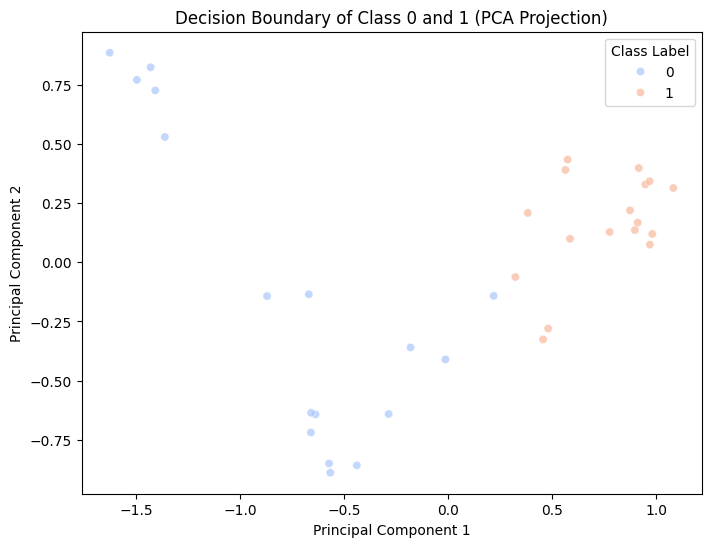

In [ ]:
from sklearn.decomposition import PCA
import seaborn as sns

# Reduce embeddings to 2D
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(nodes_wv)

# Plot decision regions
plt.figure(figsize=(8, 6))
sns.scatterplot(x=embeddings_2d[:, 0], y=embeddings_2d[:, 1], hue=labels, palette="coolwarm", alpha=0.7)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("Decision Boundary of Class 0 and 1 (PCA Projection)")
plt.legend(title="Class Label")
plt.show()


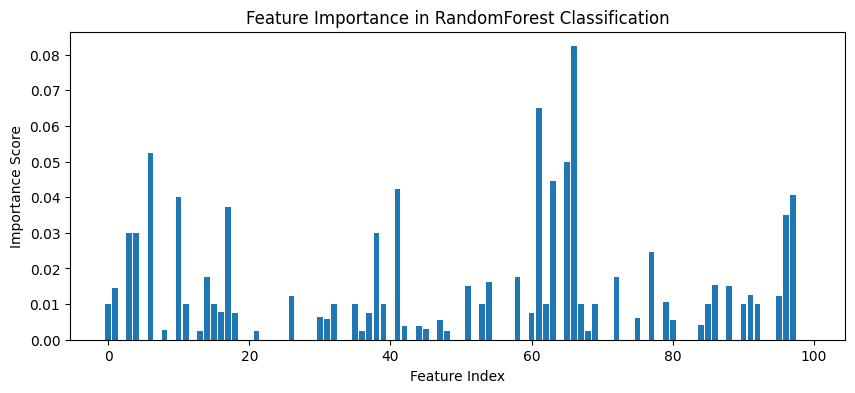

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Get feature importance
feature_importance = clf.feature_importances_

# Plot feature importance
plt.figure(figsize=(10, 4))
plt.bar(range(len(feature_importance)), feature_importance)
plt.xlabel("Feature Index")
plt.ylabel("Importance Score")
plt.title("Feature Importance in RandomForest Classification")
plt.show()
